In [1]:
%pip install sqlalchemy psycopg2-binary pandas python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 4.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [8]:

import os
import pandas as pd
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
from typing import Optional



# --- Config DB ---
DB_HOST = os.getenv("PGHOST", "postgres")   # 'postgres' si estás en el mismo docker network; 'localhost' si ejecutas fuera
DB_PORT = int(os.getenv("PGPORT", "5432"))
DB_NAME = os.getenv("PGDATABASE", "bbdd_api_youtube")
DB_USER = os.getenv("PGUSER", "postgres")
DB_PASS = os.getenv("PGPASSWORD", "postgres")

engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

def run_query(sql: str, params: Optional[dict] = None) -> pd.DataFrame:
    with engine.connect() as conn:
        df = pd.read_sql(text(sql), conn, params=params)
    return df

print(f"Conectando a {DB_NAME}@{DB_HOST}:{DB_PORT} como {DB_USER} ... listo.")


Conectando a bbdd_api_youtube@postgres:5432 como postgres ... listo.


Filas: 7


,channel,avg_dur_min,avg_likes,avg_comments,ratio_likes,ratio_comments
0,Mathologer,24.464583,15846.125000,1484.178571,0.001544,0.016484
1,El Traductor de Ingeniería,22.290854,16791.133574,514.003610,0.001328,0.043367
2,3Blue1Brown,15.008482,95621.250000,2191.343750,0.000157,0.006849
3,QuantumFracture,10.992704,76055.049057,1890.266038,0.000145,0.005815
4,Veritasium,10.962942,206185.488938,10329.506637,0.000053,0.001061
5,ElectroBOOM,7.970275,155205.370370,3774.706553,0.000051,0.002111
6,BBC Timestamp,6.611576,2024.000000,187.187192,0.003267,0.035321


<Figure size 640x480 with 0 Axes>

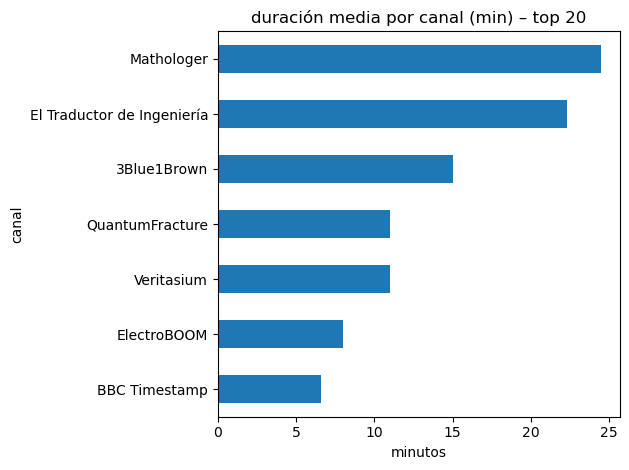

In [9]:

sql_1 = """
-- con los ratios de comments y likes por duración de video
WITH per_channel_base AS (
  SELECT
    c.name AS channel,
    AVG(v.duration)::float / 60.0 AS avg_dur_min,
    AVG(v.like_count)::float      AS avg_likes,
    AVG(v.comment_count)::float   AS avg_comments
  FROM public.video v
  JOIN public.channel c ON c.id = v.id_channel
  WHERE v.duration IS NOT NULL
    AND v.like_count IS NOT NULL
    AND v.comment_count IS NOT NULL
  GROUP BY c.name
),
per_channel AS (
  SELECT
    channel,
    avg_dur_min,
    avg_likes,
    avg_comments,
    avg_dur_min / NULLIF(avg_likes,0)    AS ratio_likes,
    avg_dur_min / NULLIF(avg_comments,0) AS ratio_comments
  FROM per_channel_base
)
SELECT *
FROM per_channel
ORDER BY avg_dur_min DESC;
"""
df_ratios = run_query(sql_1)
print("Filas:", len(df_ratios))
display(df_ratios.head(20))

# (Opcional) gráfico rápido: duración media por canal (top 20)
plt.figure()
df_ratios.sort_values("avg_dur_min", ascending=False).head(20).plot(
    x="channel", y="avg_dur_min", kind="barh", legend=False
)
plt.title("duración media por canal (min)")
plt.xlabel("minutos")
plt.ylabel("canal")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Filas: 14


,channel,periodo,r_pearson,n
0,3Blue1Brown,escolar,0.547650,193
1,3Blue1Brown,vacaciones,0.913607,31
2,BBC Timestamp,escolar,0.879604,136
3,BBC Timestamp,vacaciones,0.827928,67
4,ElectroBOOM,escolar,0.348754,298
5,ElectroBOOM,vacaciones,0.362306,53
6,El Traductor de Ingeniería,escolar,0.872913,221
7,El Traductor de Ingeniería,vacaciones,0.764430,56
8,Mathologer,escolar,0.595940,93
9,Mathologer,vacaciones,0.923612,19


,channel,periodo,r_pearson,n
0,3Blue1Brown,escolar,0.547650,193
1,3Blue1Brown,vacaciones,0.913607,31
2,BBC Timestamp,escolar,0.879604,136
3,BBC Timestamp,vacaciones,0.827928,67
6,El Traductor de Ingeniería,escolar,0.872913,221
7,El Traductor de Ingeniería,vacaciones,0.764430,56
8,Mathologer,escolar,0.595940,93
12,Veritasium,escolar,0.603537,368
13,Veritasium,vacaciones,0.575136,84


<Figure size 640x480 with 0 Axes>

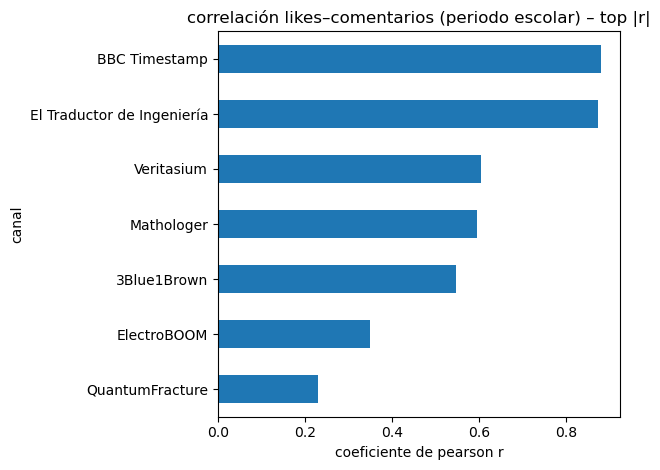

In [10]:

sql_2 = """
WITH base AS (
  SELECT
    c.name                       AS channel,
    v.like_count::float          AS likes,
    v.comment_count::float       AS comments,
    CASE
      WHEN EXTRACT(MONTH FROM v.published_at) IN (7,8) THEN 'vacaciones'
      ELSE 'escolar'
    END                          AS periodo
  FROM public.video v
  JOIN public.channel c ON c.id = v.id_channel
  WHERE v.like_count IS NOT NULL
    AND v.comment_count IS NOT NULL
    AND v.published_at IS NOT NULL
)
SELECT
  channel,
  periodo,
  corr(likes, comments)  AS r_pearson,
  COUNT(*)               AS n
FROM base
GROUP BY channel, periodo
HAVING COUNT(*) >= 5           -- mínimo tamaño muestral
ORDER BY channel, periodo;
"""
df_corr = run_query(sql_2)
print("Filas:", len(df_corr))
display(df_corr.head(30))

'''
# (Opcional) ejemplo de selección: canales con >= 20 observaciones por periodo y |r| >= 0.5
df_corr_sig = df_corr[(df_corr["n"] >= 20) & (df_corr["r_pearson"].abs() >= 0.5)].sort_values(["channel","periodo"])
display(df_corr_sig.head(30))

# (Opcional) gráfico: r por canal en periodo 'escolar' (top |r|)
try:
    df_escolar = df_corr[df_corr["periodo"]=="escolar"].dropna(subset=["r_pearson"])
    top = df_escolar.reindex(df_escolar.r_pearson.abs().sort_values(ascending=False).index).head(20)
    plt.figure()
    top.plot(x="channel", y="r_pearson", kind="barh", legend=False)
    plt.title("correlación likes–comentarios (periodo escolar) – top |r|")
    plt.xlabel("coeficiente de pearson r")
    plt.ylabel("canal")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("No se pudo graficar:", e)
